In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sma
import statsmodels.stats.api as smsa
from statsmodels.graphics.gofplots import qqplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

import category_encoders as ce

In [124]:
data = pd.read_excel('flight data.xlsx')

In [125]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [126]:
data[data['Duration']=='5m']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327


In [127]:
print('Rows:',data.shape[0])
print('Columns:',data.shape[1])

Rows: 10683
Columns: 11


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [129]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10683.0,9087.064121,4611.359167,1759.0,5277.0,8372.0,12373.0,79512.0


In [130]:
data.describe(include=object).T

,count,unique,top,freq
Airline,10683,12,Jet Airways,3849
Date_of_Journey,10683,44,18/05/2019,504
Source,10683,5,Delhi,4537
Destination,10683,6,Cochin,4537
Route,10682,128,DEL → BOM → COK,2376
Dep_Time,10683,222,18:55,233
Arrival_Time,10683,1343,19:00,423
Duration,10683,368,2h 50m,550
Total_Stops,10682,5,1 stop,5625
Additional_Info,10683,10,No info,8345


### Lets explore the columns first and try to get maximum information out of columns

In [131]:
# Airline
data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [132]:
# Date of journey
data['Date_of_Journey']=pd.to_datetime(data['Date_of_Journey'],
                                       format='%d/%m/%Y')

In [133]:
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data['Jouney_wkday'] = data['Date_of_Journey'].dt.weekday

In [134]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,6
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,6
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,4


In [135]:
# Source and destination
data['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [136]:
data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [137]:
data['Destination'] = np.where(data['Destination']=='New Delhi',
                              'Delhi',data['Destination'])

In [138]:
data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [139]:
# Route

In [140]:
busy_routes = data['Route'].value_counts().head(7).index

In [141]:
data['Route'].value_counts().head(7).index

Index(['DEL → BOM → COK', 'BLR → DEL', 'CCU → BOM → BLR', 'CCU → BLR',
       'BOM → HYD', 'CCU → DEL → BLR', 'BLR → BOM → DEL'],
      dtype='object')

In [142]:
# 1 --> Busy, 0 --> Not Busy
data['Route'] = data['Route'].apply(lambda route: 1 if route in busy_routes else 0)

In [143]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday
0,IndiGo,2019-03-24,Banglore,Delhi,1,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6
1,Air India,2019-05-01,Kolkata,Banglore,0,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2
2,Jet Airways,2019-06-09,Delhi,Cochin,0,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,6
3,IndiGo,2019-05-12,Kolkata,Banglore,0,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,6
4,IndiGo,2019-03-01,Banglore,Delhi,0,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,4


In [144]:
# Dep time and arrival time
data['Dep_Time'] = pd.to_datetime(data['Dep_Time'],format='%H:%M')

In [145]:
data['Dep_hour'] = data['Dep_Time'].dt.hour

In [146]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6,22
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,13:15,7h 25m,2 stops,No info,7662,1,5,2,5
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,04:25 10 Jun,19h,2 stops,No info,13882,9,6,6,9
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,23:30,5h 25m,1 stop,No info,6218,12,5,6,18
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,21:35,4h 45m,1 stop,No info,13302,1,3,4,16


In [147]:
# 12am to 6am : Early morning --0
# 6am to 12noon: Morning --1
# 12 6 pm: Afternoon-- 2
# after 6 pm: evening -- 3
def hour(h):
    if h>=0 and h<=6:
        return 0
    elif h>6 and h<=12:
        return 1
    elif h>12 and h<=18:
        return 2
    else:
        return 3
    

In [148]:
data['Dep_hour']= data['Dep_hour'].apply(hour)

In [149]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6,3
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,13:15,7h 25m,2 stops,No info,7662,1,5,2,0
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,04:25 10 Jun,19h,2 stops,No info,13882,9,6,6,1
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,23:30,5h 25m,1 stop,No info,6218,12,5,6,2
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,21:35,4h 45m,1 stop,No info,13302,1,3,4,2


In [150]:
data['Arrival_Time']=pd.to_datetime(data['Arrival_Time'])

In [151]:
data['Arri_hour']= data['Arrival_Time'].dt.hour

In [152]:
data['Arri_hour'] = data['Arri_hour'].apply(hour)

In [153]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,6,3,0
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,2023-11-28 13:15:00,7h 25m,2 stops,No info,7662,1,5,2,0,2
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,2023-06-10 04:25:00,19h,2 stops,No info,13882,9,6,6,1,0
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,2023-11-28 23:30:00,5h 25m,1 stop,No info,6218,12,5,6,2,3
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,2023-11-28 21:35:00,4h 45m,1 stop,No info,13302,1,3,4,2,3


In [154]:
# Duration
data[['Dur_h','Dur_m']] = data['Duration'].str.split(expand=True)

In [155]:
data[data['Duration']=='5m']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour,Dur_h,Dur_m
6474,Air India,2019-03-06,Mumbai,Hyderabad,0,1900-01-01 16:50:00,2023-11-28 16:55:00,5m,2 stops,No info,17327,6,3,2,2,2,5m,None


In [156]:
data.drop(index=[6474],inplace=True)

In [157]:
data['Dur_h'] = data['Dur_h'].str.replace('h','').astype(int)

In [158]:
data['Dur_m']=np.where(data['Dur_m'].isnull(),'0m',data['Dur_m'])

In [159]:
data['Dur_m'] = data['Dur_m'].str.replace('m','').astype(int)

In [160]:
data['Duration'] = (data['Dur_h']*60) + data['Dur_m']

In [161]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour,Dur_h,Dur_m
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,2023-03-22 01:10:00,170,non-stop,No info,3897,24,3,6,3,0,2,50
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,2023-11-28 13:15:00,445,2 stops,No info,7662,1,5,2,0,2,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,2023-06-10 04:25:00,1140,2 stops,No info,13882,9,6,6,1,0,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,2023-11-28 23:30:00,325,1 stop,No info,6218,12,5,6,2,3,5,25
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,2023-11-28 21:35:00,285,1 stop,No info,13302,1,3,4,2,3,4,45


In [162]:
# stops
data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1519
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [163]:
stop_map = {'non-stop':0,
           '1 stop':1,
           '2 stops':2,
           '3 stops':3,
           '4 stops':4}
data['Total_Stops'] = data['Total_Stops'].map(stop_map)

In [164]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour,Dur_h,Dur_m
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,2023-03-22 01:10:00,170,0.0,No info,3897,24,3,6,3,0,2,50
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,2023-11-28 13:15:00,445,2.0,No info,7662,1,5,2,0,2,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,2023-06-10 04:25:00,1140,2.0,No info,13882,9,6,6,1,0,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,2023-11-28 23:30:00,325,1.0,No info,6218,12,5,6,2,3,5,25
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,2023-11-28 21:35:00,285,1.0,No info,13302,1,3,4,2,3,4,45


In [165]:
# Additional Info
data['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [166]:
# Lets make 1 --> Info, 0 --> No info
data['Additional_Info'] = data['Additional_Info'].apply(lambda x:0 if x in \
['No info','No Info'] else 1 )

In [167]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour,Dur_h,Dur_m
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,2023-03-22 01:10:00,170,0.0,0,3897,24,3,6,3,0,2,50
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,2023-11-28 13:15:00,445,2.0,0,7662,1,5,2,0,2,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,2023-06-10 04:25:00,1140,2.0,0,13882,9,6,6,1,0,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,2023-11-28 23:30:00,325,1.0,0,6218,12,5,6,2,3,5,25
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,2023-11-28 21:35:00,285,1.0,0,13302,1,3,4,2,3,4,45


#### We can drop columns which we do not need any more

In [168]:
data.columns
del_cols = ['Date_of_Journey','Dep_Time', 'Arrival_Time','Dur_h','Dur_m']

In [169]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour,Dur_h,Dur_m
0,IndiGo,2019-03-24,Banglore,Delhi,1,1900-01-01 22:20:00,2023-03-22 01:10:00,170,0.0,0,3897,24,3,6,3,0,2,50
1,Air India,2019-05-01,Kolkata,Banglore,0,1900-01-01 05:50:00,2023-11-28 13:15:00,445,2.0,0,7662,1,5,2,0,2,7,25
2,Jet Airways,2019-06-09,Delhi,Cochin,0,1900-01-01 09:25:00,2023-06-10 04:25:00,1140,2.0,0,13882,9,6,6,1,0,19,0
3,IndiGo,2019-05-12,Kolkata,Banglore,0,1900-01-01 18:05:00,2023-11-28 23:30:00,325,1.0,0,6218,12,5,6,2,3,5,25
4,IndiGo,2019-03-01,Banglore,Delhi,0,1900-01-01 16:50:00,2023-11-28 21:35:00,285,1.0,0,13302,1,3,4,2,3,4,45


In [170]:
data.drop(columns=del_cols,inplace=True)

In [171]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
0,IndiGo,Banglore,Delhi,1,170,0.0,0,3897,24,3,6,3,0
1,Air India,Kolkata,Banglore,0,445,2.0,0,7662,1,5,2,0,2
2,Jet Airways,Delhi,Cochin,0,1140,2.0,0,13882,9,6,6,1,0
3,IndiGo,Kolkata,Banglore,0,325,1.0,0,6218,12,5,6,2,3
4,IndiGo,Banglore,Delhi,0,285,1.0,0,13302,1,3,4,2,3


## Univariate Analysis

In [172]:
data.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month',
       'Jouney_wkday', 'Dep_hour', 'Arri_hour'],
      dtype='object')

In [173]:
cat_cols = ['Airline', 'Source', 'Destination', 'Route','Total_Stops',
       'Additional_Info','Journey_month',
       'Jouney_wkday', 'Dep_hour', 'Arri_hour']
num_cols = ['Duration','Journey_day','Price']

In [174]:
# Lets us see distribution of number columns

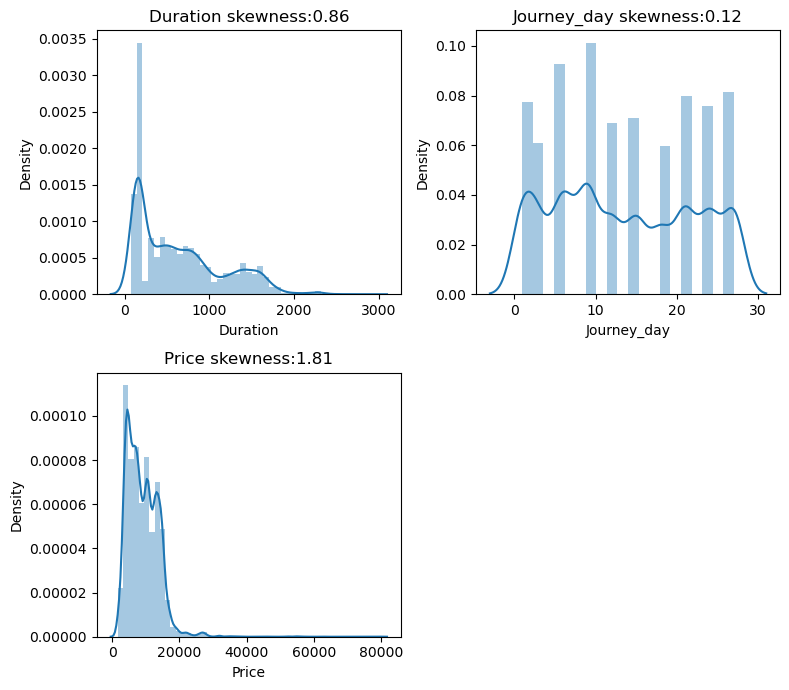

In [175]:
plt.figure(figsize=(8,7))
t = 1
for i in num_cols:
    plt.subplot(2,2,t)
    sns.distplot(data[i])
    plt.title(f'{i} skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

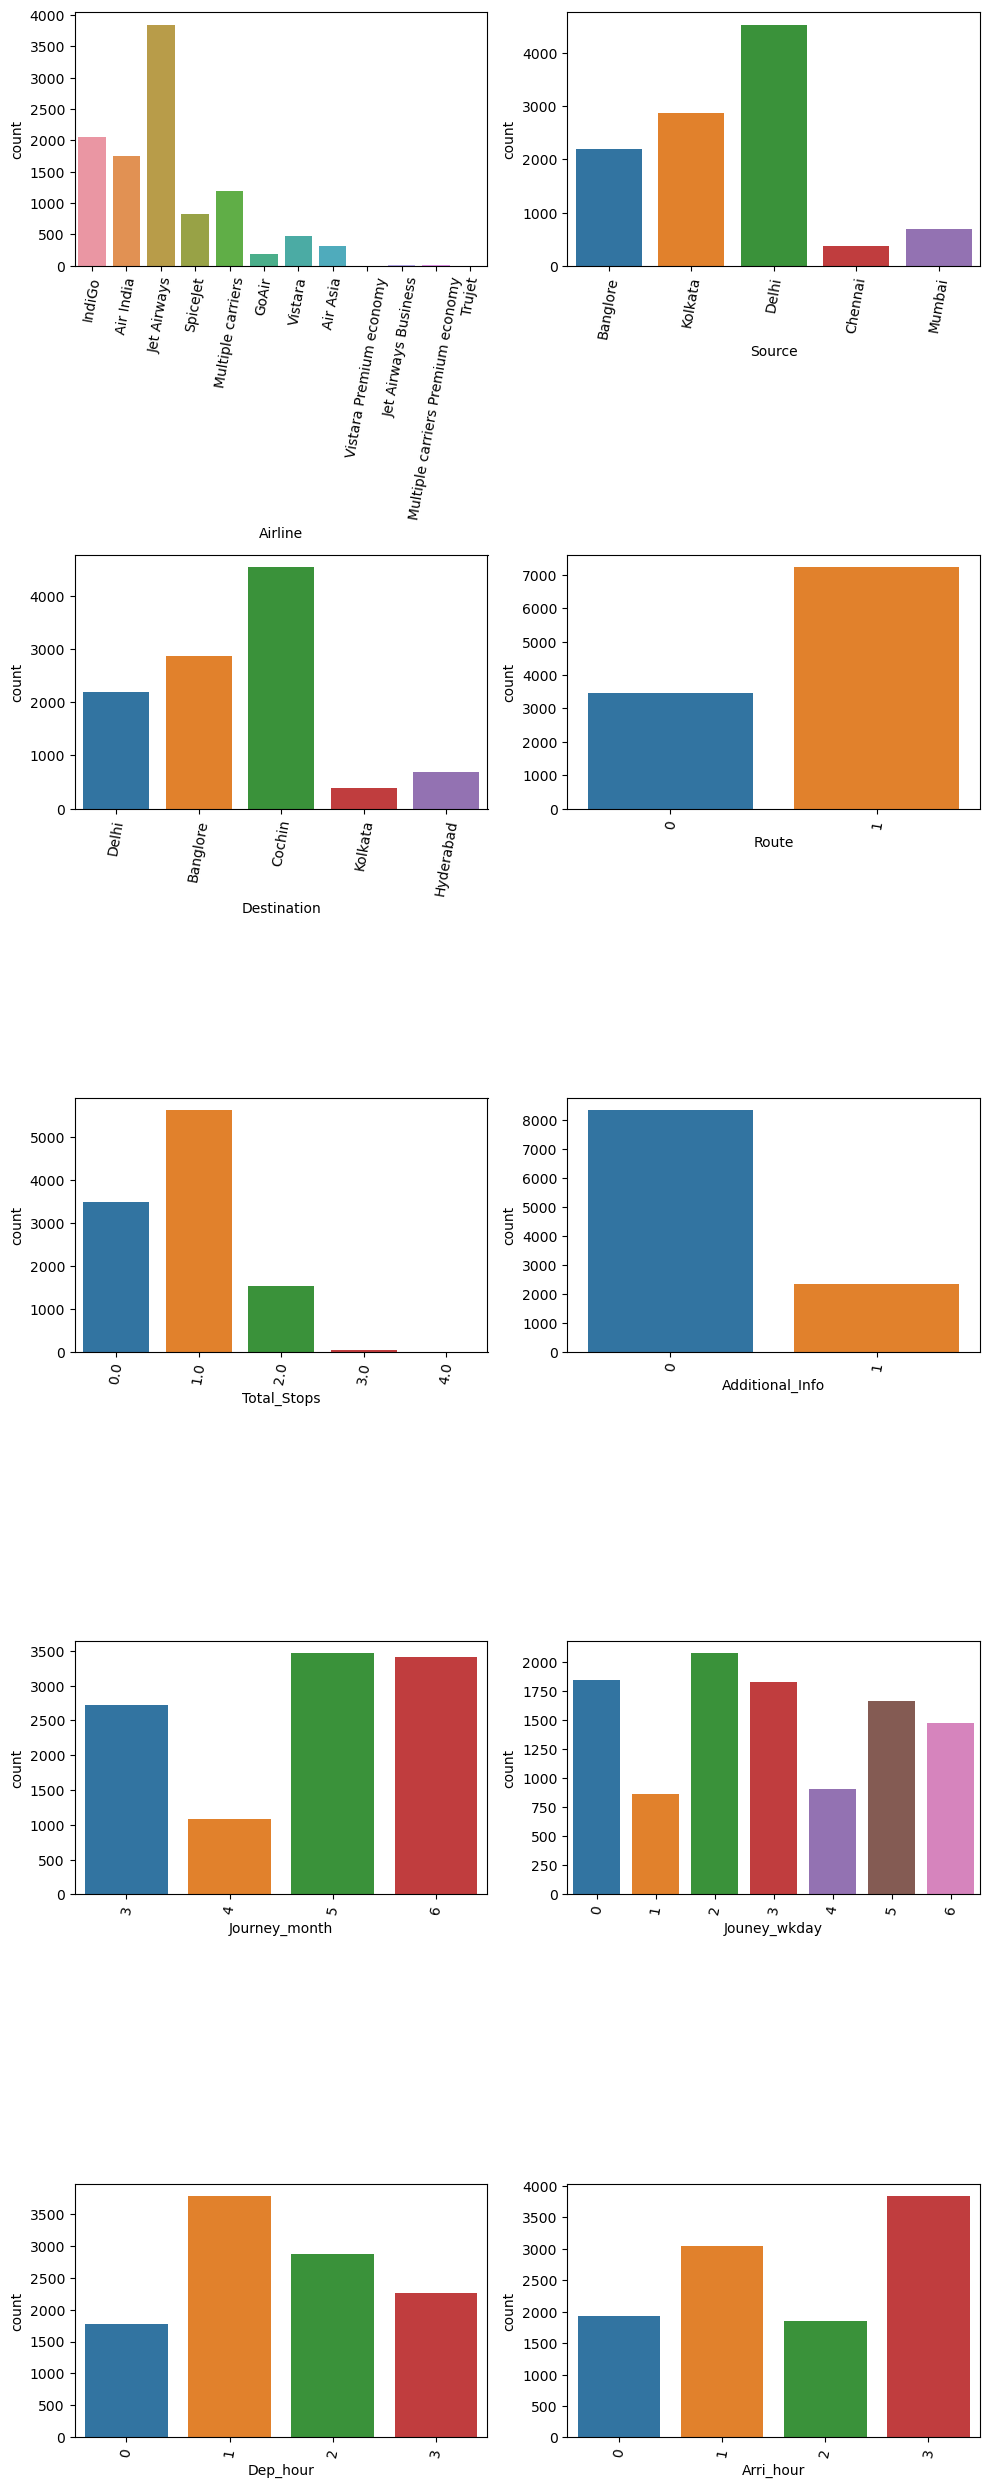

In [176]:
plt.figure(figsize=(10,30))
t = 1
for i in cat_cols:
    plt.subplot(6,2,t)
    sns.countplot(data = data, x=i)
    plt.xticks(rotation=80)
    t+=1
plt.tight_layout()
plt.show()

## Bivariate Analysis

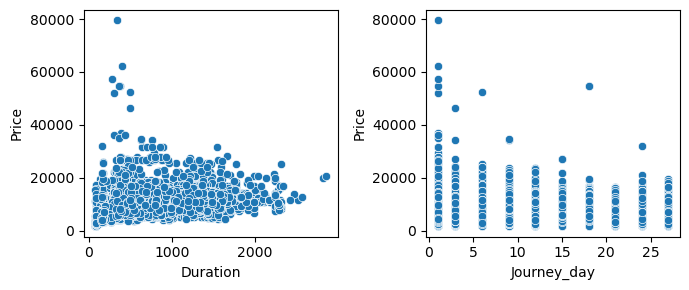

In [177]:
plt.figure(figsize=(7,3))
t = 1
for i in num_cols:
    if i != 'Price':
        plt.subplot(1,2,t)
        sns.scatterplot(x=data[i],y=data['Price'])
        t+=1
plt.tight_layout()
plt.show()

<Axes: >

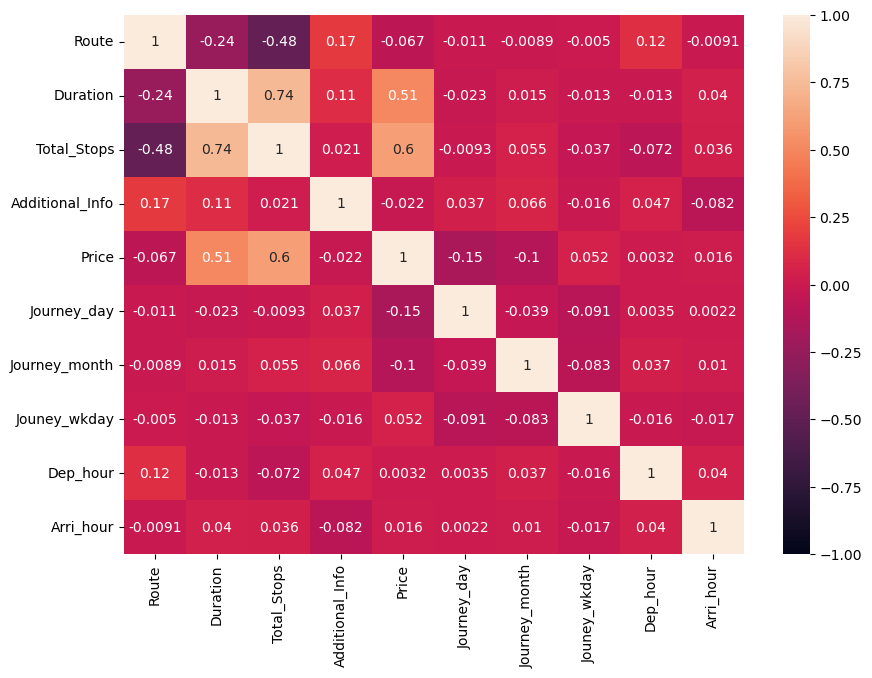

In [178]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),vmax=1,vmin=-1,annot=True)

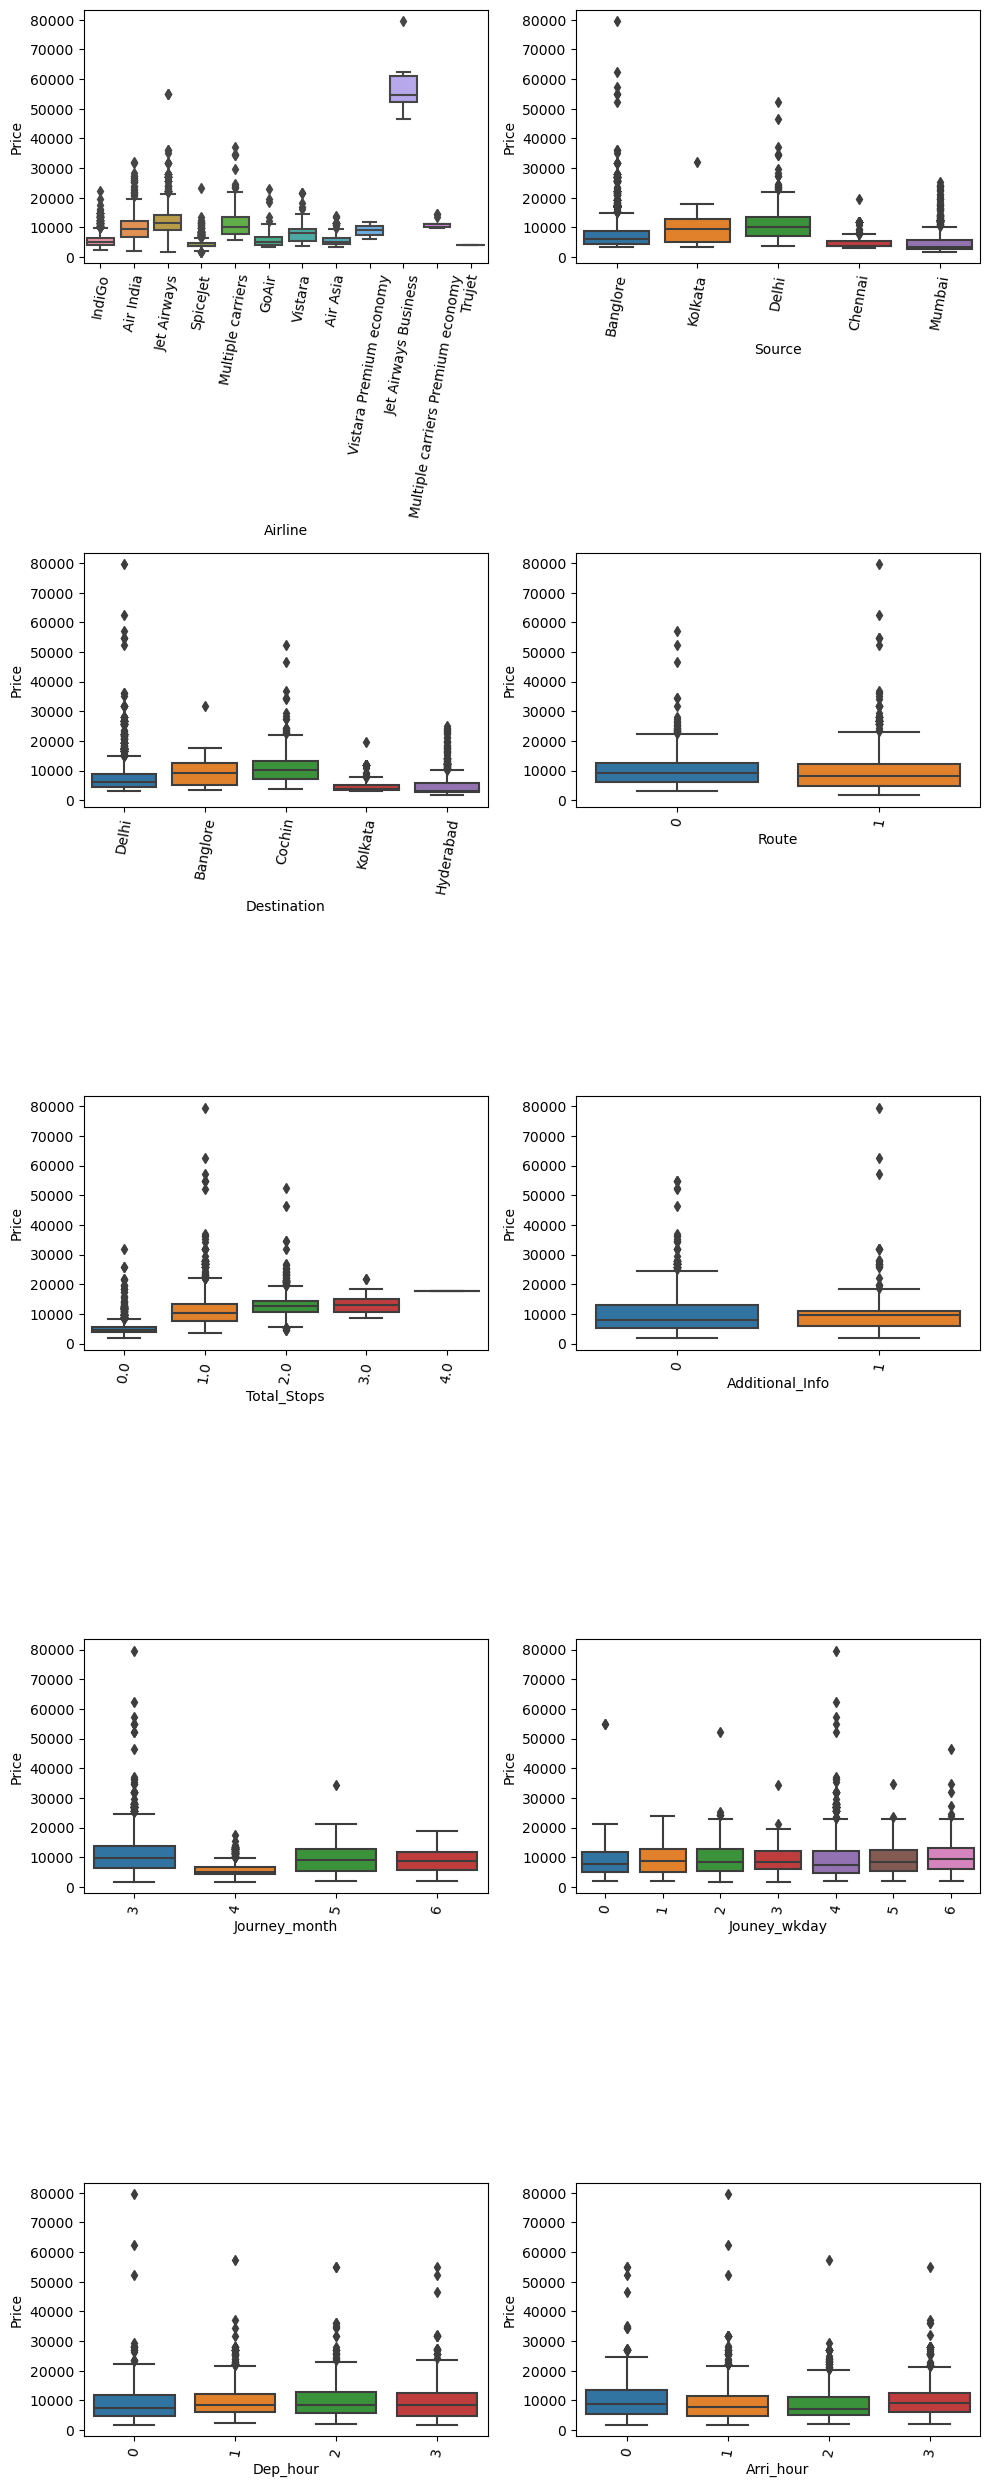

In [179]:
plt.figure(figsize=(10,30))
t = 1
for i in cat_cols:
    plt.subplot(6,2,t)
    sns.boxplot(x=data[i],y=data['Price'])
    plt.xticks(rotation=80)
    t+=1
plt.tight_layout()
plt.show()

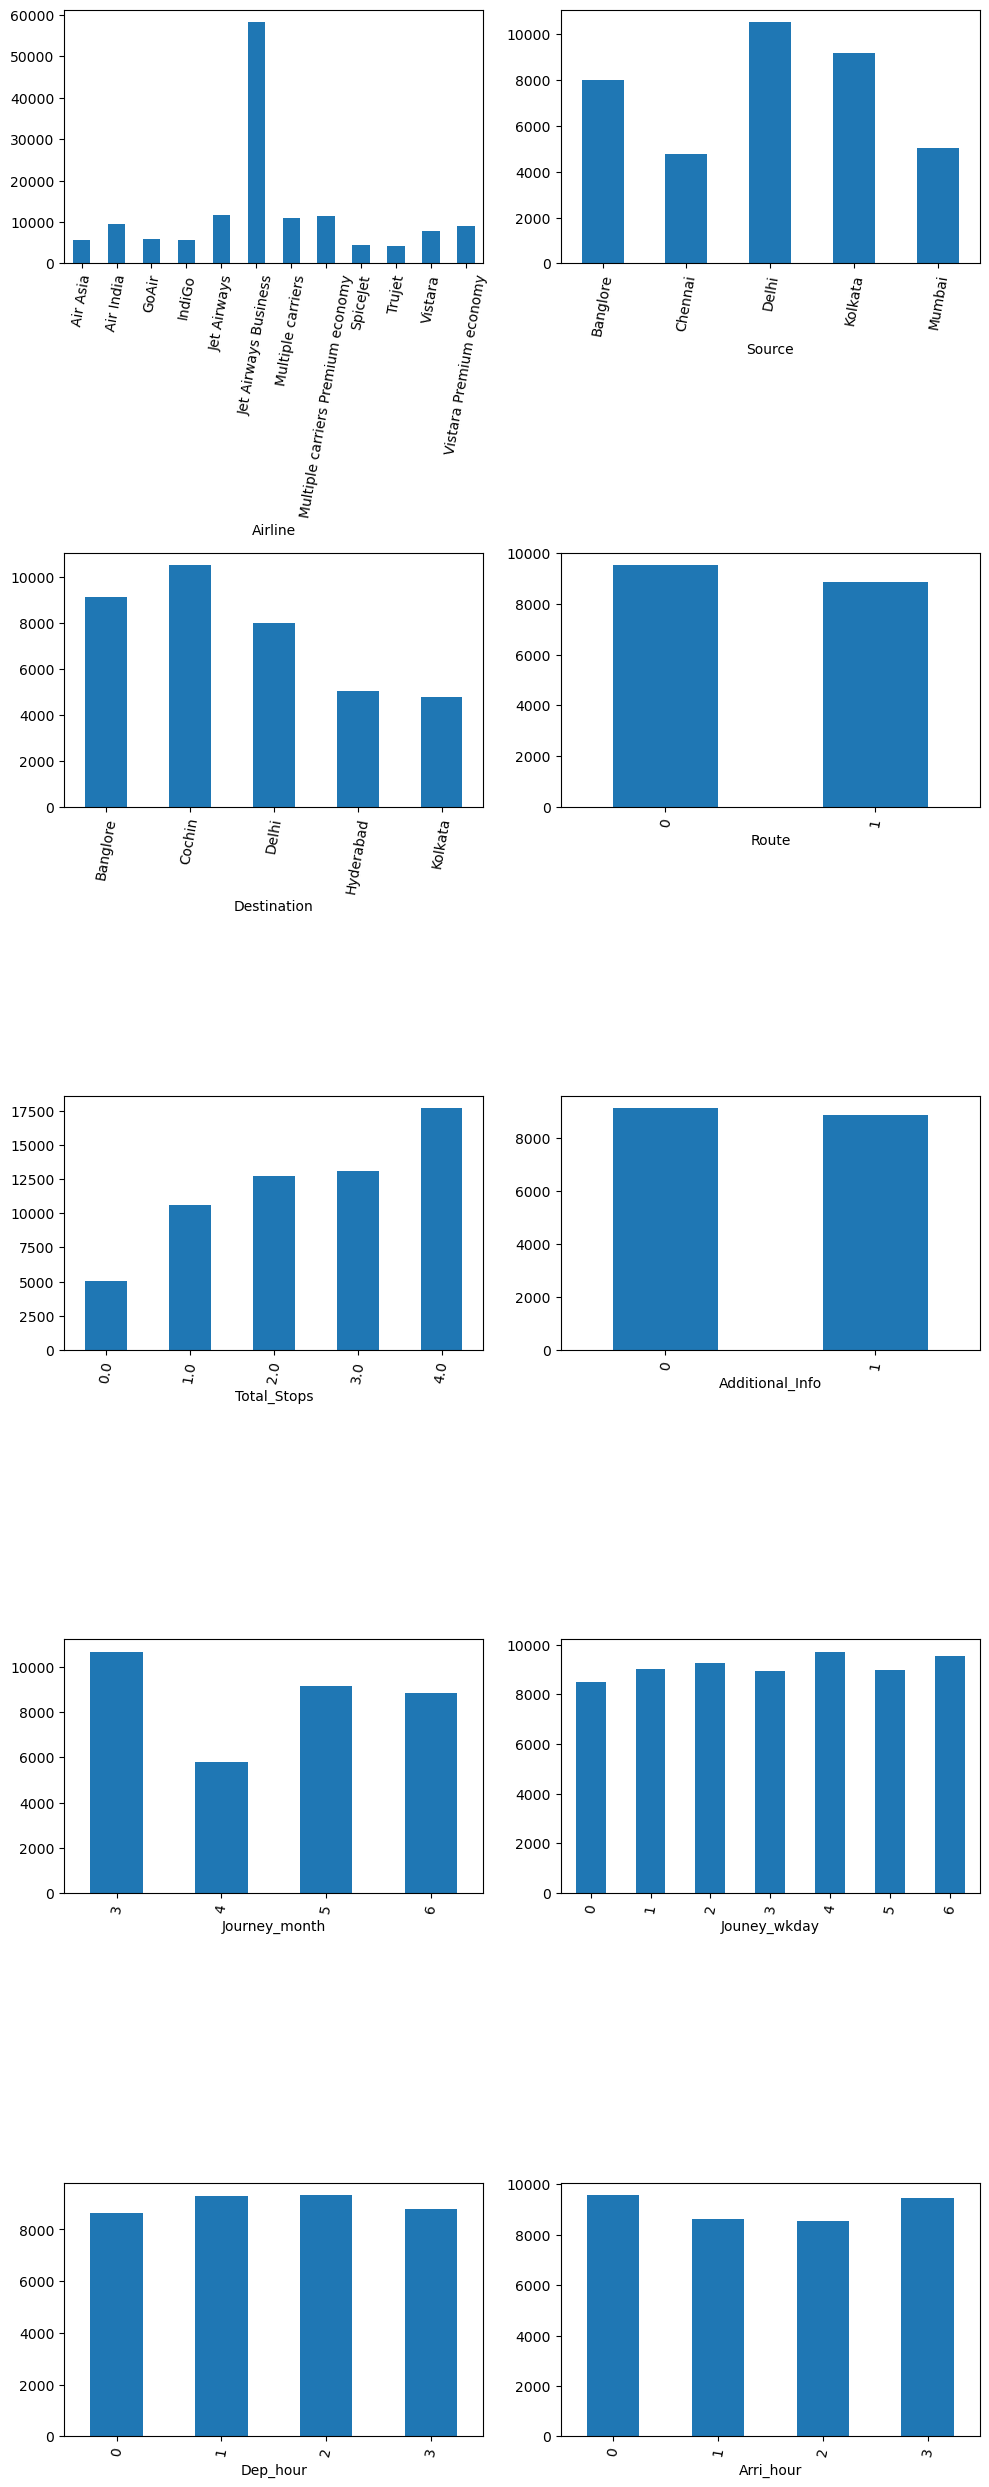

In [180]:
plt.figure(figsize=(10,30))
t = 1
for i in cat_cols:
    plt.subplot(6,2,t)
    data.groupby(by=i)["Price"].mean().plot(kind='bar')
    plt.xticks(rotation=80)
    t+=1
plt.tight_layout()
plt.show()

## Missing Value treatment

In [181]:
data.isnull().sum()

Airline            0
Source             0
Destination        0
Route              0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
Journey_day        0
Journey_month      0
Jouney_wkday       0
Dep_hour           0
Arri_hour          0
dtype: int64

In [182]:
data[data['Total_Stops'].isnull()]

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
9039,Air India,Delhi,Cochin,0,1420,NaN,0,7480,6,5,0,1,1


In [183]:
data.drop(index=[9039],inplace=True)

### Outlier Treatment

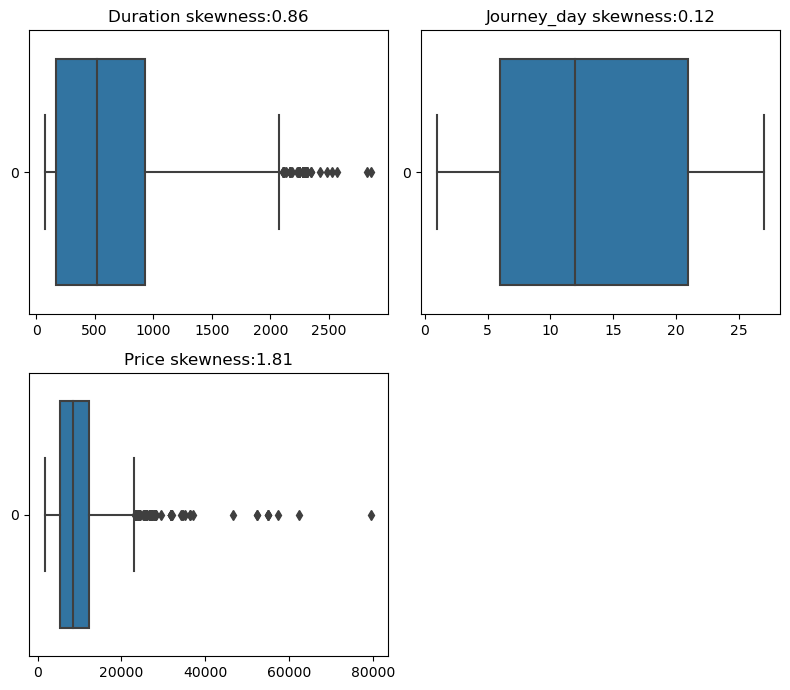

In [184]:
plt.figure(figsize=(8,7))
t = 1
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data[i],orient='h')
    plt.title(f'{i} skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [185]:
# Capping
q3,q1 = data['Price'].quantile([0.75,0.25])
iqr = q3-q1
ul = q3 + 5*(iqr)
ul

47853.0

In [186]:
data['Price'][data['Price']>ul]=ul

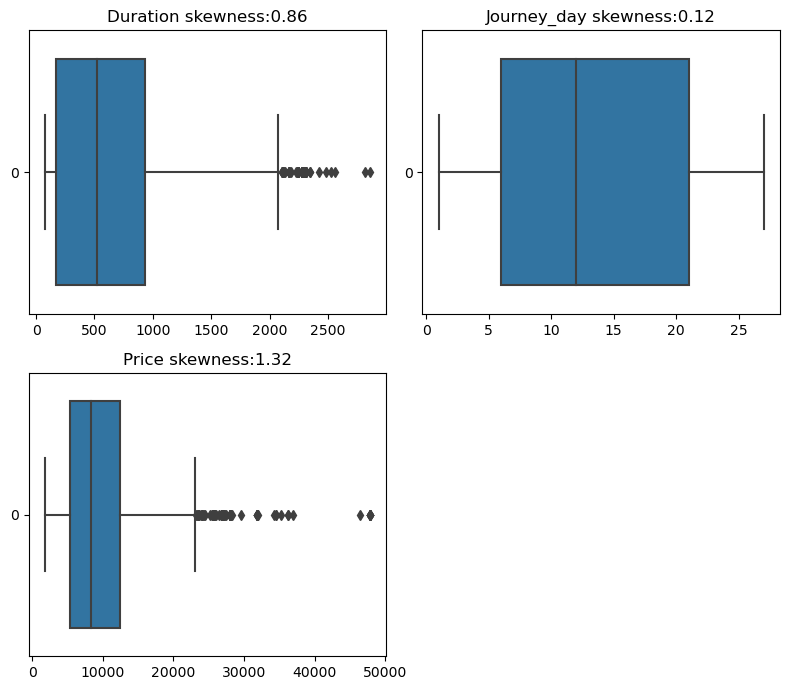

In [187]:
plt.figure(figsize=(8,7))
t = 1
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data[i],orient='h')
    plt.title(f'{i} skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Encoding

In [188]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
0,IndiGo,Banglore,Delhi,1,170,0.0,0,3897,24,3,6,3,0
1,Air India,Kolkata,Banglore,0,445,2.0,0,7662,1,5,2,0,2
2,Jet Airways,Delhi,Cochin,0,1140,2.0,0,13882,9,6,6,1,0
3,IndiGo,Kolkata,Banglore,0,325,1.0,0,6218,12,5,6,2,3
4,IndiGo,Banglore,Delhi,0,285,1.0,0,13302,1,3,4,2,3


In [189]:
data.groupby(by='Source')['Price'].mean()

Source
Banglore     7980.648612
Chennai      4789.892388
Delhi       10539.136464
Kolkata      9158.389411
Mumbai       5042.083333
Name: Price, dtype: float64

In [190]:
data.groupby(by='Destination')['Price'].mean()

Destination
Banglore      9158.389411
Cochin       10539.136464
Delhi         7980.648612
Hyderabad     5042.083333
Kolkata       4789.892388
Name: Price, dtype: float64

### Train test split

In [191]:
x = data.drop(columns=['Price','Destination'])
y = data['Price']

In [192]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=3)

In [193]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(8544, 11) (8544,) (2137, 11) (2137,)


### Catboost encoding

In [194]:
for i in ['Airline','Source']:
    cat_e = ce.CatBoostEncoder()
    cat_e.fit(x_train[i],y_train)
    x_train[i] = cat_e.transform(x_train[i])
    x_test[i] = cat_e.transform(x_test[i])

In [195]:
x_train['Airline'].value_counts()

11710.936458    3063
5655.252017     1639
9582.715814     1416
10820.668726     958
4334.530902      640
7793.141027      377
5548.839504      265
5871.120166      168
11042.664368      10
41164.218009       5
10000.436017       2
9083.308052        1
Name: Airline, dtype: int64

In [196]:
x_test['Airline'].value_counts()

11710.936458    786
5655.252017     414
9582.715814     334
10820.668726    238
4334.530902     178
7793.141027     102
5548.839504      54
5871.120166      26
11042.664368      3
41164.218009      1
10000.436017      1
Name: Airline, dtype: int64

In [197]:
x_train.head(7)

,Airline,Source,Route,Duration,Total_Stops,Additional_Info,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
8843,5655.252017,5167.516044,1,90,0.0,0,15,5,2,0,0
136,11710.936458,10508.208797,0,1300,2.0,0,6,6,3,0,0
6244,11710.936458,10508.208797,1,610,1.0,1,18,5,5,2,0
402,9582.715814,10508.208797,0,1585,3.0,0,15,6,5,0,1
7119,11710.936458,10508.208797,0,810,2.0,0,6,6,3,0,3
7589,11710.936458,10508.208797,0,1615,2.0,1,24,6,0,1,1
4855,5655.252017,8018.702847,1,170,0.0,0,3,5,4,3,3


In [198]:
x_train_c = sma.add_constant(x_train)
x_test_c = sma.add_constant(x_test)

### Lets check the assumptions for Linear Regression Model

Checks Before we fit the model

* Variables muste be numeric
* There should be no multicolinearity

Checks after fitting the model

* Linear relation
* Absence of Autocorelation
* Error terms must be homoscedastic
* Error terms must follow N(0,1)

#### Lets check for multicoliniarity

In [200]:
# Using VIF
vif = [variance_inflation_factor(x_train_c.values,i) for i in range(x_train_c.shape[1])]

In [201]:
pd.DataFrame({'VIF':vif},index=x_train_c.columns).\
sort_values(by='VIF',ascending=False)

,VIF
const,62.231367
Total_Stops,3.992465
Duration,2.348940
Route,1.708796
Airline,1.672166
Source,1.598499
Additional_Info,1.157606
Journey_month,1.043089
Dep_hour,1.025493
Journey_day,1.025329


In [202]:
x_train_c.head()

,const,Airline,Source,Route,Duration,Total_Stops,Additional_Info,Journey_day,Journey_month,Jouney_wkday,Dep_hour,Arri_hour
8843,1.0,5655.252017,5167.516044,1,90,0.0,0,15,5,2,0,0
136,1.0,11710.936458,10508.208797,0,1300,2.0,0,6,6,3,0,0
6244,1.0,11710.936458,10508.208797,1,610,1.0,1,18,5,5,2,0
402,1.0,9582.715814,10508.208797,0,1585,3.0,0,15,6,5,0,1
7119,1.0,11710.936458,10508.208797,0,810,2.0,0,6,6,3,0,3


In [203]:
y_train

8843     2754
136     13376
6244    12373
402     10493
7119    13014
        ...  
6400    10588
9162     3687
9861     7050
1688     7530
5994     9397
Name: Price, Length: 8544, dtype: int64

### Build a Base Model

In [204]:
base_model = sma.OLS(y_train,x_train_c).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1288.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:06:28   Log-Likelihood:                -79906.
No. Observations:                8544   AIC:                         1.598e+05
Df Residuals:                    8532   BIC:                         1.599e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1952.9319    238.162      8.200      0.000    1486.077    2419.787
Airline             0.7404      0.014     53.872      0.000       0.713       0.767
Source              0.0548      0.023      2.382      0.017       0.010       0.100
Route            1402.1311     84.250     16.642      0.000    1236.981    1567.282
Duration           -0.1148      0.091     -1.257      0.209      -0.294       0.064
Total_Stops      3283.3139     89.395     36.728      0.000    3108.078    3458.550
Additional_Info -1995.2534     78.911    -25.285      0.000   -2149.937   -1840.569
Journey_day       -70.8271      3.615    -19.590      0.000     -77.914     -63.740
Journey_month    -551.3574     26.481    -20.821      0.000    -603.266    -499.449
Jouney_wkday      136.2548     15.163      8.986      0.000     106.532     165.978
Dep_hour          100.9332     30.499      3.309      0.001      41.147     160.719
Arri_hour        -140.9904     26.899     -5.241      0.000    -193.719     -88.262
==============================================================================
Omnibus:                     4247.218   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79744.216
Skew:                           1.940   Prob(JB):                         0.00
Kurtosis:                      17.455   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

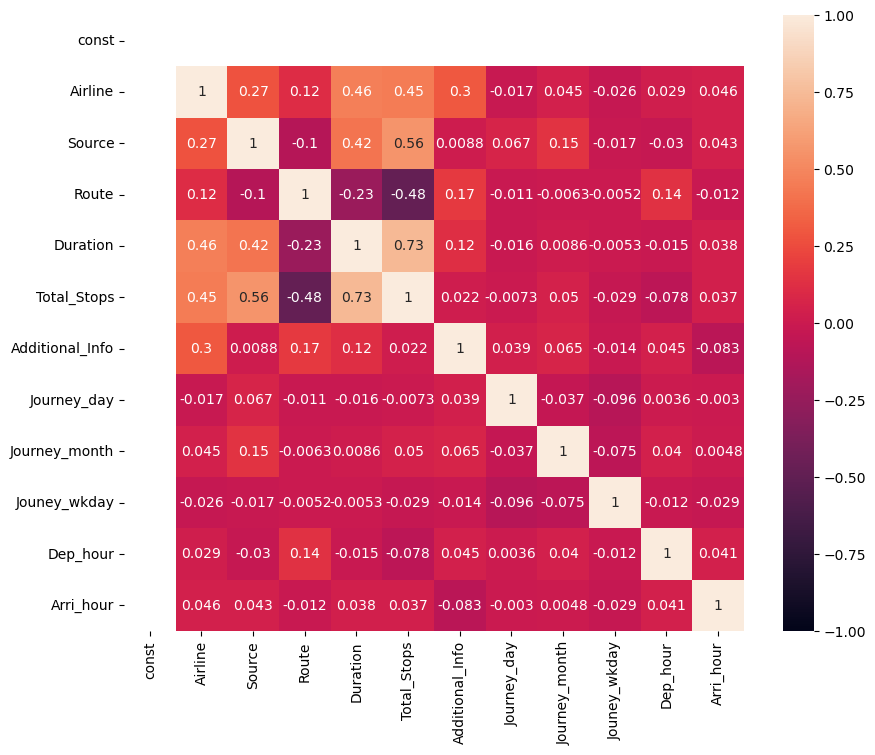

In [205]:
plt.figure(figsize=(10,8))
sns.heatmap(x_train_c.corr(),annot=True,vmax=1,vmin=-1)

### Lets check the model is linear or not

In [206]:
p = smsa.linear_rainbow(base_model)[1]
p

0.03965655925271036

In [207]:
if p< 0.05:
    print('Reject Ho: The model is not linear')
else:
    print('Fail to reject Ho: The model is linear')

Reject Ho: The model is not linear


### Check for Autocorrelation

### Check for Homoscedasticity

In [208]:
# Residual plot to check the Homoscedasticity
y_pred_train = base_model.predict(x_train_c)

<Axes: ylabel='Price'>

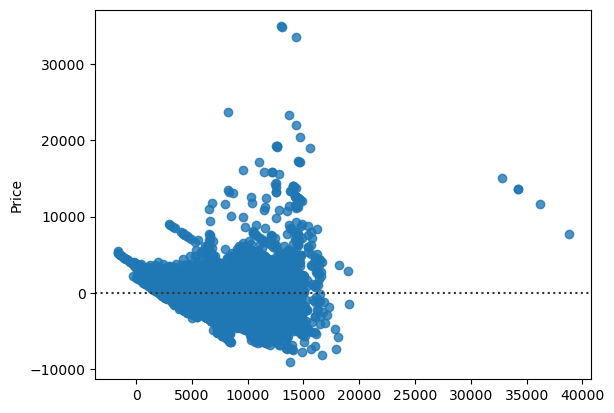

In [209]:
sns.residplot(x=y_pred_train,y=y_train)

In [210]:
base_model.resid.sort_values()

1571     -9105.652789
5050     -8085.504625
5082     -7795.937929
7948     -7444.180970
1369     -7406.816118
             ...     
396      23303.662655
10052    23667.286323
5439     33547.666819
2618     34773.989385
1478     34873.775008
Length: 8544, dtype: float64

### Normality of Residuals

<Axes: ylabel='Density'>

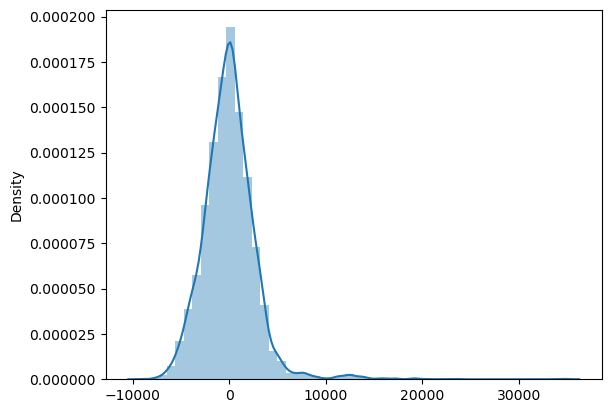

In [211]:
sns.distplot(base_model.resid)

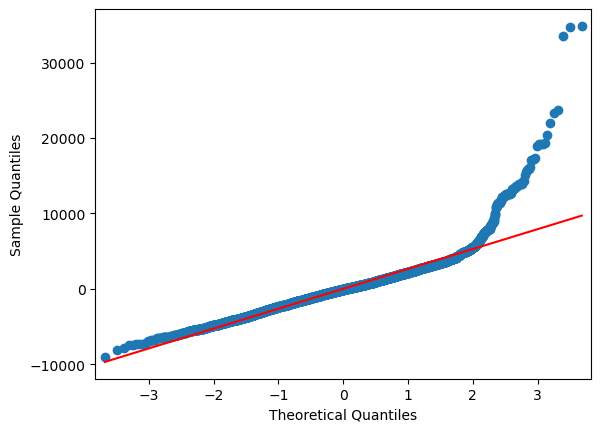

In [212]:
qqplot(base_model.resid,line='r')
plt.show()

In [213]:
import scipy.stats as stats

In [214]:
p = stats.jarque_bera(base_model.resid)[1]
# Ho: The Resid is normal
# Ha: Resid is not normal
print('Reject Ho: Resid is not normal')

Reject Ho: Resid is not normal


Assumption Summary
* There is no multicolinearity in dataset
* The model is not able to establish a linear relation bw the target and predictor variable.
* Autocorrelation is not present
* Residual are not Homoscedastic
* The residuals does not follow N(0,1)

## lets validate the Base Model

In [215]:
def validation(fitted_model,xtrain,ytrain,xtest,ytest):
    y_pred_test = fitted_model.predict(xtest)
    r2 = r2_score(ytest,y_pred_test)
    print('R2:',r2)
    n = xtrain.shape[0]
    k = xtrain.shape[1]
    adj_r2 = 1 - (((1-r2)*(n-1))/(n-k-1))
    print('Adj R2:',adj_r2)
    print('MSE:',mean_squared_error(ytest,y_pred_test))
    print('RMSE:',np.sqrt(mean_squared_error(ytest,y_pred_test)))
    print('MAE:',mean_absolute_error(ytest,y_pred_test))
    print('MAPE:',mean_absolute_percentage_error(ytest,y_pred_test))  

In [216]:
validation(base_model,x_train_c,y_train,x_test_c,y_test)

R2: 0.6302256118876324
Adj R2: 0.6297054744292632
MSE: 7303470.031752503
RMSE: 2702.4932991133396
MAE: 1921.3255644065766
MAPE: 0.2596121145288748


## Lets try Sklearn Models 

In [217]:
def model_validation(model,xtrain,ytrain,xtest,ytest):
    global m
    m = model.fit(xtrain,ytrain)
    print('%s'%model)
    print('Train parameters:')
    validation(m,xtrain,ytrain,xtrain,ytrain)
    print()
    print('Test parameters:')
    validation(m,xtrain,ytrain,xtest,ytest)   

In [218]:
# Linear Regression
model_validation(LinearRegression(),x_train,y_train,x_test,y_test)

LinearRegression()
Train parameters:
R2: 0.6241224635022492
Adj R2: 0.6236378581457707
MSE: 7776526.492959354
RMSE: 2788.6424103780955
MAE: 1950.8831235052232
MAPE: 0.2584939241556954

Test parameters:
R2: 0.6302256118876302
Adj R2: 0.6297488751003311
MSE: 7303470.031752547
RMSE: 2702.493299113348
MAE: 1921.3255644065878
MAPE: 0.25961211452887945


It seems the Linear regression is underfitted over here

In [219]:
# Stochastic Gradient Descent (Scalled data)
model_validation(SGDRegressor(eta0=0.1),x_train,y_train,x_test,y_test)

SGDRegressor(eta0=0.1)
Train parameters:
R2: -7.561769403856577e+27
Adj R2: -7.571518520528215e+27
MSE: 1.564453695494836e+35
RMSE: 3.955317554248756e+17
MAE: 3.800295026078477e+17
MAPE: 48749423617260.89

Test parameters:
R2: -7.928152858616145e+27
Adj R2: -7.938374340266962e+27
MSE: 1.565901497549373e+35
RMSE: 3.957147327999519e+17
MAE: 3.801992565191059e+17
MAPE: 49127022537704.195


In [220]:
# Regularization : Regularization may affect the performance because model is underfitted
# Lasso
model_validation(Lasso(alpha=100),x_train,y_train,x_test,y_test)

Lasso(alpha=100)
Train parameters:
R2: 0.6070404296285862
Adj R2: 0.6065338010216845
MSE: 8129936.516367243
RMSE: 2851.304353513887
MAE: 1981.1049832965423
MAPE: 0.2536569707945454

Test parameters:
R2: 0.6127460994260978
Adj R2: 0.6122468269335624
MSE: 7648710.533898012
RMSE: 2765.6302236376455
MAE: 1949.9370595285302
MAPE: 0.2543621156677378


In [221]:
pd.DataFrame({'Coef':m.coef_},index=x_train.columns)

,Coef
Airline,0.798561
Source,0.202831
Route,136.408409
Duration,0.438931
Total_Stops,1990.584984
Additional_Info,-1294.481416
Journey_day,-73.707838
Journey_month,-500.550429
Jouney_wkday,106.494249
Dep_hour,0.000000


In [222]:
# Lasso
model_validation(Ridge(alpha=1000),x_train,y_train,x_test,y_test)

Ridge(alpha=1000)
Train parameters:
R2: 0.6016943432669819
Adj R2: 0.6011808221436741
MSE: 8240541.64220698
RMSE: 2870.6343623329985
MAE: 1996.4099399822474
MAPE: 0.25555629671761293

Test parameters:
R2: 0.6085911744277641
Adj R2: 0.6080865451402238
MSE: 7730775.087812675
RMSE: 2780.4271412523426
MAE: 1964.8010143496756
MAPE: 0.256145773908586


In [223]:
pd.DataFrame({'Coef':m.coef_},index=x_train.columns)

,Coef
Airline,0.796943
Source,0.263117
Route,247.420099
Duration,0.771626
Total_Stops,1589.171183
Additional_Info,-1155.671819
Journey_day,-75.758577
Journey_month,-533.788884
Jouney_wkday,122.671703
Dep_hour,70.815353


### Other Algoritms (Models)

In [224]:
model_validation(KNeighborsRegressor(n_neighbors=6),x_train,y_train,x_test,y_test)

KNeighborsRegressor(n_neighbors=6)
Train parameters:
R2: 0.7727515130424063
Adj R2: 0.7724585297610498
MSE: 4701541.6131983455
RMSE: 2168.303856289138
MAE: 1396.9403870162296
MAPE: 0.1529350285443924

Test parameters:
R2: 0.6682297831832629
Adj R2: 0.6678020438038695
MSE: 6552843.879529974
RMSE: 2559.8523159608203
MAE: 1692.6861644049288
MAPE: 0.19070437046712868


In [225]:
model_validation(DecisionTreeRegressor(max_depth=8),x_train,y_train,x_test,y_test)

DecisionTreeRegressor(max_depth=8)
Train parameters:
R2: 0.8658540373004686
Adj R2: 0.8656810877470585
MSE: 2775344.444832727
RMSE: 1665.936506843141
MAE: 1091.1691358457315
MAPE: 0.12670398815551642

Test parameters:
R2: 0.8291421976546063
Adj R2: 0.8289219168498947
MSE: 3374638.3720374806
RMSE: 1837.0188817857809
MAE: 1145.2792953648816
MAPE: 0.13208335309418953


In [226]:
model_validation(GradientBoostingRegressor(n_estimators=300,max_depth=5),x_train,y_train,x_test,y_test)

GradientBoostingRegressor(max_depth=5, n_estimators=300)
Train parameters:
R2: 0.9416372233753393
Adj R2: 0.9415619783515616
MSE: 1207466.886298109
RMSE: 1098.8479814324223
MAE: 687.0662660227068
MAPE: 0.08235931709903586

Test parameters:
R2: 0.9021870716429575
Adj R2: 0.9020609649608282
MSE: 1931917.9855056077
RMSE: 1389.934525618242
MAE: 825.1108966974474
MAPE: 0.0971799124102695


## K-Fold Validation

In [227]:
kfcv = KFold(n_splits=5,random_state=1,shuffle=True)

In [228]:
model = GradientBoostingRegressor(n_estimators=300,max_depth=5)

In [229]:
score = cross_val_score(estimator=model,
                       X=x_train,y=y_train,
                       cv=kfcv,scoring='r2')
score

array([0.90825653, 0.88387076, 0.88936949, 0.90323468, 0.86517369])

In [230]:
print('Sum:',np.mean(score),'Std dev:',np.std(score))

Sum: 0.8899810303958576 Std dev: 0.01524969882703483
